# Lindblad and 2 dimensional electronic spectra simulation code.

In what follows I exemplify how to use my code for:
(1) constructing arbitrary Lindblad matrix and using it for density matrix propagation.
(2) Simulating 2 dimensional electronic spectra using Lindblad matrix constructed in (1) for simulating dynamics in the dark.



In [2]:
#import sys
#sys.path.append("/Users/dbo/Documents/project/code/tools/")
import Lind2DNNmethods as LM
import twoDES_methods as twoD

import matplotlib.pyplot as plt

## Lindblad methods

We can construct an arbitrary lindblad matrix as follows:

In [3]:
import numpy as np

Hamiltonian = np.array([[0, -80],[-80, 800]], dtype=np.complex128)# 2 Chromophore Hamiltonian matrix borrowed from Mukamel: 
#Palmieri, Abramavicius, and Mukamel, ‘Lindblad Equations for Strongly Coupled Populations and Coherences in Photosynthetic Complexes’.


sim = LM.Lind2DNN(Hamiltonian, E_reorgs=[10], vec="row", eigenbasis=False)  

'sim' is a class object with defined parameter that we can use to extract Unitary dynamics propagation matrix and Dissipator matrix components from Lindblad equation. 
\
Hamiltonian has expected unit of $cm^{-1}$.

We can pass a bunch of different parameters to it: 

\
temperature: T_K, integer in Kelvin

\
reorganization energy : E_reorgs, a list with elements in  $cm^{-1}$.
One or more if we want to specify different reorganization energies for each "site".
\
cutoff frequency : w_cutoffs, a list of variable parametes for each site's bath.


\ 

eigenbasis = True/False, defines in which basis Lindblad matrix should be constructed.

\

unit : $"s1": 1, "ms1" : 10^-3, "us1" : 10^-6, "ns1" : 10^-9, "ps1" : 10^-12, "fs1" : 10^-15$
defines unit scaling of Lindblad matrix.

\

vec: vectorization procedure either columnwise("col") or rowwise("row"), columnwise way is described below.


# Lindblad  matrix contruction

We take the full form:

$\dot{\rho}(t) = \mathcal{L}\rho(t) = -i \left[ H, \rho(t)\right] + \mathcal{D}(\rho(t))$ 

, where we hide dissipator part inside $\mathcal{D}(\rho(t))$:

$\mathcal{D}(\rho(t)) = \sum_{n} \left[ A_{m} \rho(t) A^{\dagger}_{m} - \frac{1}{2}\left( A^{\dagger}_m A_m \rho(t) + \rho(t) A^{\dagger}_m A_m\right) \right] $

I can then transform it from above superoperator from into a matrix defined on larger Hilbert space, where I perform following isomorphism: 

$$ \mathcal{H} \rightarrow \mathcal{H} \times \mathcal{H}$$ 

I make use of following isomorphism that is consistent with respect to Hilbert Schmidt inner product:

For 3 matrices A,B,C $\in \mathbb{C}^{n^{2}}$: 

$ABC = C^{T} \otimes A \vert{B} \rangle \rangle$,

where $\otimes$ is Kroenecker product, T is matrix transpose operation and $\vert{B} \rangle \rangle$ is columnwise vectorized matrix B. By columnwise I mean the following transformation:

$$ B = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix} \rightarrow \begin{bmatrix} B_{11} \\ B_{21} \\B_{12}\\ B_{22} \end{bmatrix}$$


For the case above it gives us following form of Lindblad matrix: 

$$ \mathbf{L} = -i \left[ \mathbb{1}\otimes H - H^{T} \otimes \mathbb{1}\right] + \mathbf{D}$$ 

$$ \mathbf{D} = \sum_{n} \gamma_{n} \left(A^{*}_m \otimes A_m -\frac{1}{2} \left[\mathbb{1} \otimes A^{\dagger}_m A_m \right] -\frac{1}{2} \left[\left(A^{\dagger}_m A_m\right)^{T} \otimes \mathbb{1} \right]    \right) $$

# Dissipator construction
Constructed using a list of Lindblad operators and corresponding rates(can be computed either using the class method: \

sim.build_lindblad_rate_ops(bath_function), which outputs pure dephasing and relaxation operators and rates respectively. \

or provided manually.

\

At the moment there is only one bath function: ohmic 
which presumes that each site is coupled to its own bath continuum and baths at different sites are not intercorrelated.

In [4]:
operators_D, operators_R, rates_D, rates_R = sim.build_lindblad_rate_ops(sim.build_ohmic_bath)


dissipator_dephasing = sim.lindblad_dissipator(operators_D, rates_D)

dissipator_relaxation = sim.lindblad_dissipator(operators_R, rates_R)

unitary_prop = sim.unitary_dynamics()

Lindblad_matrix = unitary_prop + dissipator_relaxation + dissipator_dephasing

# Applications

I can use above constructed Lindblad matrix for propagating density matrices. I construct initial density using 
"initial_density" method, where I can choose: 

- "ground" for ground state
- "mixed"  for mixed state
- "manual" and specify manually the diagonal of density matrix.

In the first two options I also need to define dimension of the system.

It has to be appropriately flattened to be used in conjunction with Lindblad matrix.

In [5]:
p0 = sim.initial_density( density_type="ground", dim=2)
p0_f = p0.flatten("F")

# Generate plot data

get_density_plot is a generator that yield pairs of timestamps and corresponding density matrices, that then 
have to ben extracted.

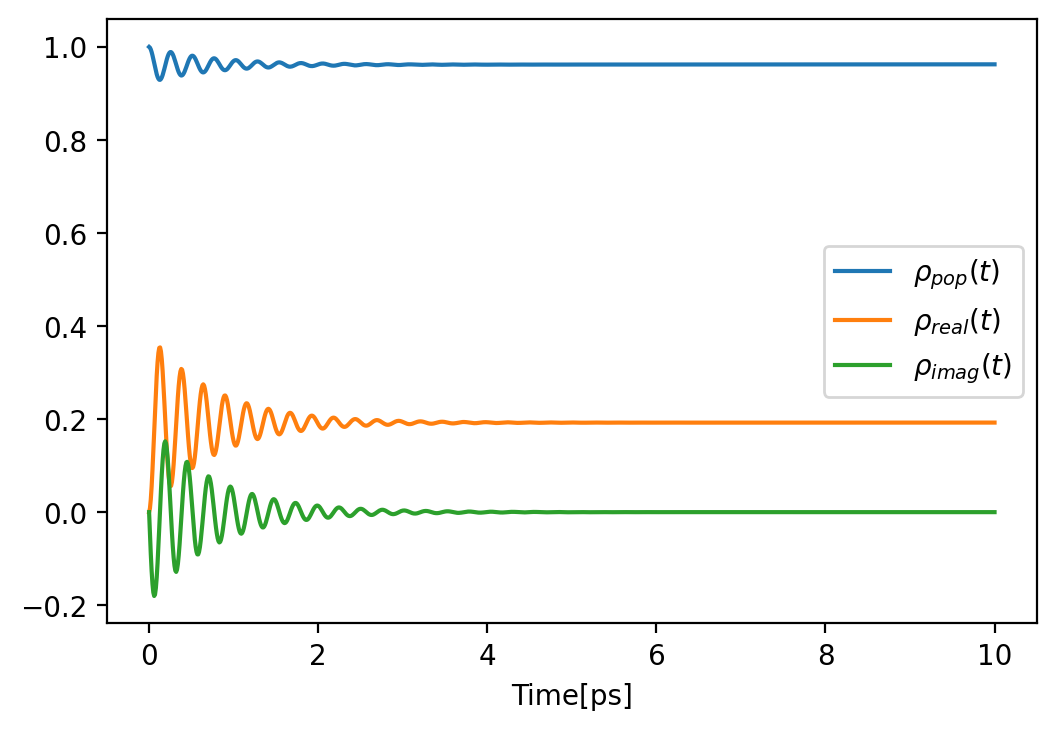

In [19]:
plt.figure(dpi=200)
ts, ys= [], []

gen = sim.get_density_plot(Lindblad_matrix, p0_f, tmin=0, tmax=10, ts =1000)
for t, y in gen:
    ts.append(t)
    ys.append(y)
    
rho_pop  = [(rho[0,0]-rho[1,1]).real for rho in ys]
rho_real = [(rho[0,1]+rho[1,0]).real for rho in ys]
rho_imag = [(1j*(rho[1,0]-rho[0,1])).real for rho in ys]

plt.plot(ts, rho_pop, label=r"$ \rho_{pop}(t)$")
plt.plot(ts, rho_real, label=r"$ \rho_{real}(t)$")
plt.plot(ts, rho_imag, label=r"$ \rho_{imag}(t)$")

plt.legend()
plt.xlabel("Time[ps]")
plt.show()
plt.close()

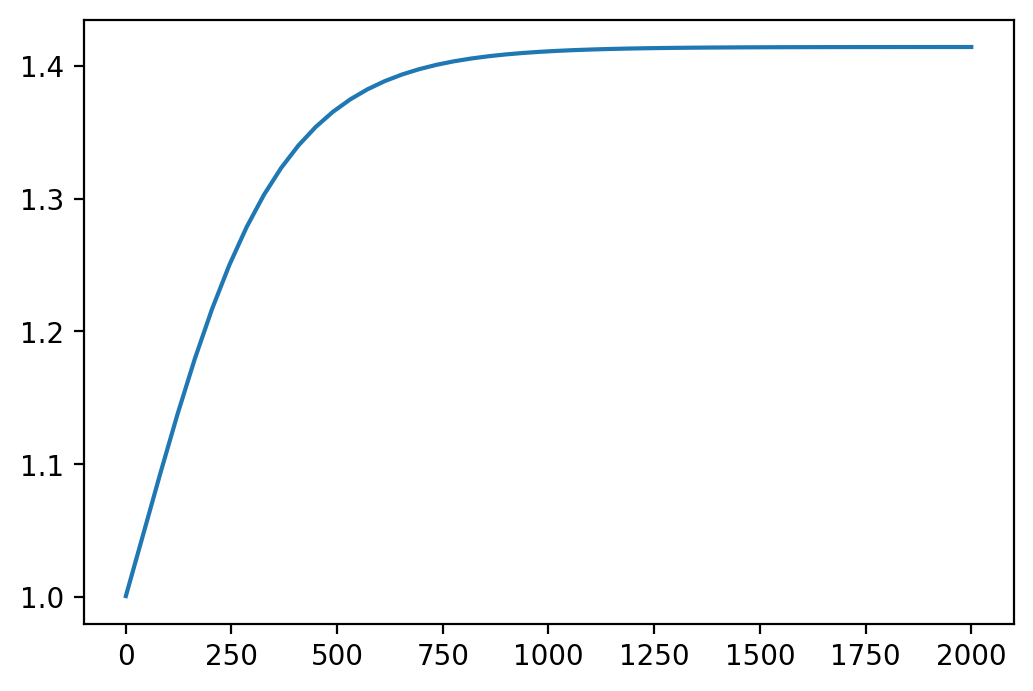

In [18]:
import scipy.linalg as LA
times = np.linspace(0.5,2000,50)
norms = [LA.norm(LA.expm(Lindblad_matrix*t),2) for t in times]
plt.figure(dpi=200)


plt.plot(times, norms)
plt.show()
plt.close()

# 2 dimensional spectroscopy using Lindblad matrix for system propagation in the waiting time

We will reuse the constructed Lindblad matrix and density matrix for passing them inside twodimspec class. Although any other $N^{2} \times N^{2}, dim(\mathcal{H})=N$ complex matrix $\mathbf{M}$ that propagates density matrix in one step(corresponding master equation has to be Markovian) should also work, given we can write its action as follows: \
$$ e^{\mathbf{M}t}\rho(0) = \rho(t) $$.

Inspired by work of Anda et al. $\textit{Anda, Abramavičius, and Hansen, ‘Two-Dimensional Electronic Spectroscopy of Anharmonic Molecular Potentials’.}$ \
We are able to plot our 2 D spectrum  plots directly in frequency space(Given here in $cm^{-1}$ units). \
w1s, w3s : arrays describing first and second plotting axis. can also be thought of as Fourier transformed time delays between 1st and 2nd, and 3rd and 4th pulses respectively. \
t2s: waiting times between 2nd and 3rd pulses, \
diagrams: we can choose which of the 4(for now) diagrams we would like to compute, by passing a list of strings with any of the names: 


["SE", "SE2", "GSB", "GSB2"]. 


Their conjugated parts are: 


["SE_c", "SE2_c", "GSB_c", "GSB2_c"] 


Those correspond to non-rephasing stimulated emission(R1), rephasing stimulated emission(R2), non-rephasing ground state bleach(R3) and rephasing ground state bleach(R4) respectively. Two sided Feynmann diagrams representing them can be seen below: 




The current formulation only works in eigenstate representation.

In [27]:
Hamiltonian = np.array([[0, -80],[-80, 800]], dtype=np.complex128)

sim = LM.Lind2DNN(Hamiltonian, E_reorgs=[10], vec="row", eigenbasis=True) 

operators_D, operators_R, rates_D, rates_R = sim.build_lindblad_rate_ops(sim.build_ohmic_bath)


dissipator_dephasing = sim.lindblad_dissipator(operators_D, rates_D)

dissipator_relaxation = sim.lindblad_dissipator(operators_R, rates_R)

unitary_prop = sim.unitary_dynamics()

Lindblad_matrix = unitary_prop + dissipator_relaxation + dissipator_dephasing

w1_axis = np.linspace(700,900,20)
w3_axis = np.linspace(700,900,20)

t2s = [0,5, 10, 100, 1000]
spectrum_obj = twoD.twodimspec(Lindblad_matrix, p0, w1s=w1_axis, w3s=w3_axis, t2s=t2s, diagrams=["SE", "SE2", "GSB", "GSB2"])

# Generate spectrum data

In [28]:
out_slices= spectrum_obj.generate_spectrum_data()

Time elapsed:  11.944952249526978


# Plot the data

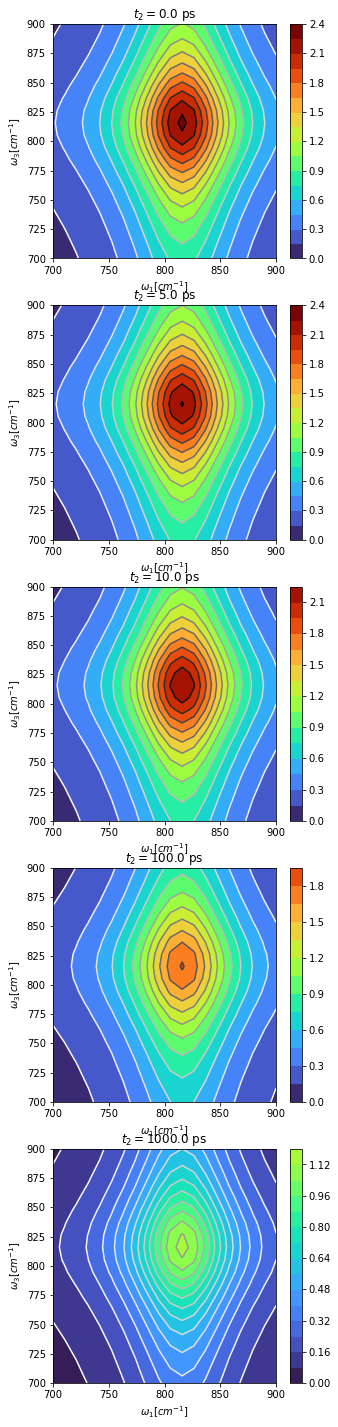

In [29]:
from decimal import Decimal
fig, ax = plt.subplots(len(t2s), figsize=(5, 5*len(t2s)))
max_val = np.max([v for v in map(np.abs, out_slices.flatten())])


for i, values in enumerate(out_slices):
        
    reals, imags, abss, phases = twoD.twodimspec.transform_data(values)
    values = abss
    X, Y = np.meshgrid(spectrum_obj.w1_axis[:], spectrum_obj.w3_axis[:])

    c1 = ax[i].contourf(X, Y, values, 15, cmap='turbo',vmin=0, vmax=max_val)# vmin=-max_val, vmax=max_val)
        
    c2 = ax[i].contour(X, Y, values, 15, cmap='Greys',vmin=0, vmax=max_val)# vmin=-max_val, vmax=max_val)
    name = r"$t_{2} = $" + str(round(Decimal(t2s[i]),1)) + " ps"

    ax[i].set_xlabel(r"$ \omega_{1} [cm^{-1}] $")
    ax[i].set_ylabel(r"$ \omega_{3} [cm^{-1}] $")
    ax[i].set_title(name)

    fig.colorbar(c1, ax=[ax[i]])